<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/best_ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata
import pandas_gbq

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
from matplotlib import pyplot
import seaborn as sns
from xgboost import XGBClassifier

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Mounted at /content/drive


In [31]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

In [24]:
# Authentication credentials and keys
# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [6]:
# Feature data for FA Cup

# Query Google Big Query
fa_cup_features_all = """
    SELECT * FROM preparation_layer.view_fa_cup_round_3_features
"""

fa_cup_features_all_df = client.query(fa_cup_features_all).to_dataframe()
display(fa_cup_features_all_df)




,season_year,arena_stadium_capacity,home_team_league_level,home_win,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,target_variable
0,09/10,41837,1,1,1,1,1,12,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
1,14/15,41837,1,1,1,1,1,12,1,1,...,34.70,0.000,0.0,0.00,4.80,1036.70,2.05,95.90,Overcast,0
2,16/17,41837,1,1,1,1,1,12,1,1,...,47.00,0.000,0.0,0.00,2.10,1031.70,4.20,87.00,Partially cloudy,0
3,20/21,74879,1,1,1,1,1,12,1,1,...,71.20,0.000,NaN,0.00,7.65,1015.50,5.15,67.10,Partially cloudy,0
4,09/10,74879,1,0,2,3,7,4,6,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,14/15,<NA>,6,0,64,58,64,53,63,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
346,17/18,9527,4,1,64,58,64,53,63,64,...,37.15,0.000,0.0,0.00,14.45,1012.75,9.00,94.25,Overcast Partially cloudy,1
347,18/19,6064,6,0,64,58,64,53,63,64,...,41.45,0.000,0.0,0.00,6.35,1036.35,15.15,98.65,Overcast,0
348,20/21,4100,6,1,64,58,64,53,63,64,...,32.75,0.001,0.0,2.36,6.45,1026.75,6.20,69.50,"Snow, Rain, Partially cloudy Partially cloudy",1


In [7]:
# Function to calculate home advantage
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

['arena_stadium_capacity',
 'home_team_league_level',
 'home_win',
 'home_lineup_strength',
 'home_team_league_form',
 'home_team_league_form_home_and_away',
 'home_team_league_promotion_relegation',
 'away_team_league_level',
 'away_lineup_strength',
 'away_team_league_form',
 'away_team_league_form_home_and_away',
 'away_team_league_promotion_relegation',
 'rivalry_flag',
 'match_weather_data_hours_feelslike',
 'match_weather_data_hours_humidity',
 'match_weather_data_hours_dew',
 'match_weather_data_hours_precip',
 'match_weather_data_hours_snow',
 'match_weather_data_hours_snowdepth',
 'match_weather_data_hours_windspeed',
 'match_weather_data_hours_pressure',
 'match_weather_data_hours_visibility',
 'match_weather_data_hours_cloudcover',
 'match_weather_data_hours_condition']

no_ranking
['arena_stadium_capacity', 'home_team_league_level', 'home_win', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_team_league_level', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_cloudcover', 'match_weather_data_hours_condition']


,arena_stadium_capacity,home_team_league_level,home_win,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,target_variable
12,53394,1,1,2,3,7,4,6,5,5,...,39.10,0.0000,0.00,0.000,19.35,1000.35,6.80,38.15,Partially cloudy Clear,0
18,41837,1,1,3,2,2,5,4,3,2,...,44.55,0.0160,0.00,0.000,10.35,992.40,12.65,62.20,"Rain, Partially cloudy",0
33,62850,1,1,5,6,5,1,3,4,4,...,47.20,0.0000,0.00,0.000,18.40,998.05,7.05,100.00,Overcast,0
40,62850,1,1,6,11,15,9,14,9,9,...,36.20,0.0000,0.00,0.000,7.60,1003.55,16.60,32.30,Partially cloudy,0
49,32050,1,1,8,21,12,7,12,10,10,...,36.90,0.0000,0.00,0.000,8.55,1001.95,18.00,45.70,Partially cloudy,0
70,42682,1,0,11,30,24,17,20,19,19,...,37.75,0.0075,0.00,0.000,7.30,986.55,15.80,46.05,"Rain, Partially cloudy",1
85,39460,1,1,14,16,19,19,24,17,18,...,26.90,0.0000,NaN,0.790,9.40,1002.50,41.45,0.00,Clear,0
95,11700,1,0,16,25,23,22,26,20,20,...,45.10,0.0045,0.00,0.000,18.00,995.80,13.20,90.05,"Rain, Overcast Rain, Partially cloudy",1
105,52409,1,0,18,19,27,11,27,18,17,...,38.20,0.0000,0.00,0.000,12.35,987.10,6.75,27.00,Partially cloudy,1
108,21944,1,0,19,37,43,26,43,31,31,...,40.90,0.0710,0.00,0.315,10.35,991.30,9.50,94.60,"Rain, Overcast",1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Actual,Predicted
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,1,1.0
6,0,0.0
7,1,0.0
8,1,1.0
9,1,0.0


,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,away_team_league_form,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,home_win_factor
0,53394,1,1,0.69,0.83,0.44,0,3,0.81,0.00,...,39.10,0.0000,0.00,0.000,19.35,1000.35,6.80,38.15,Partially cloudy Clear,0.75
1,41837,1,1,0.67,0.39,0.39,0,5,0.82,0.56,...,44.55,0.0160,0.00,0.000,10.35,992.40,12.65,62.20,"Rain, Partially cloudy",1.0
2,62850,1,1,NaN,0.00,0.39,0,3,NaN,0.28,...,47.20,0.0000,0.00,0.000,18.40,998.05,7.05,100.00,Overcast,0.75
3,62850,1,1,0.88,0.56,0.39,0,3,0.78,0.22,...,36.20,0.0000,0.00,0.000,7.60,1003.55,16.60,32.30,Partially cloudy,0.75
4,32050,1,1,0.88,0.00,0.72,1,2,0.71,0.56,...,36.90,0.0000,0.00,0.000,8.55,1001.95,18.00,45.70,Partially cloudy,0.5
5,42682,1,0,0.82,0.39,0.56,1,4,0.90,0.39,...,37.75,0.0075,0.00,0.000,7.30,986.55,15.80,46.05,"Rain, Partially cloudy",0.0
6,39460,1,1,0.82,0.00,0.11,0,2,0.76,0.28,...,26.90,0.0000,NaN,0.790,9.40,1002.50,41.45,0.00,Clear,0.5
7,11700,1,0,0.82,0.00,0.17,0,2,0.85,0.67,...,45.10,0.0045,0.00,0.000,18.00,995.80,13.20,90.05,"Rain, Overcast Rain, Partially cloudy",0.5
8,52409,1,0,0.72,0.00,0.28,0,3,0.85,0.33,...,38.20,0.0000,0.00,0.000,12.35,987.10,6.75,27.00,Partially cloudy,0.75
9,21944,1,0,0.81,0.22,0.17,0,2,0.75,0.44,...,40.90,0.0710,0.00,0.315,10.35,991.30,9.50,94.60,"Rain, Overcast",0.5


,Actual,Predicted,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,home_win_factor
0,0,0.0,53394,1,1,0.69,0.83,0.44,0,3,...,39.10,0.0000,0.00,0.000,19.35,1000.35,6.80,38.15,Partially cloudy Clear,0.75
1,0,0.0,41837,1,1,0.67,0.39,0.39,0,5,...,44.55,0.0160,0.00,0.000,10.35,992.40,12.65,62.20,"Rain, Partially cloudy",1.0
2,0,0.0,62850,1,1,NaN,0.00,0.39,0,3,...,47.20,0.0000,0.00,0.000,18.40,998.05,7.05,100.00,Overcast,0.75
3,0,0.0,62850,1,1,0.88,0.56,0.39,0,3,...,36.20,0.0000,0.00,0.000,7.60,1003.55,16.60,32.30,Partially cloudy,0.75
4,0,0.0,32050,1,1,0.88,0.00,0.72,1,2,...,36.90,0.0000,0.00,0.000,8.55,1001.95,18.00,45.70,Partially cloudy,0.5
5,1,1.0,42682,1,0,0.82,0.39,0.56,1,4,...,37.75,0.0075,0.00,0.000,7.30,986.55,15.80,46.05,"Rain, Partially cloudy",0.0
6,0,0.0,39460,1,1,0.82,0.00,0.11,0,2,...,26.90,0.0000,NaN,0.790,9.40,1002.50,41.45,0.00,Clear,0.5
7,1,0.0,11700,1,0,0.82,0.00,0.17,0,2,...,45.10,0.0045,0.00,0.000,18.00,995.80,13.20,90.05,"Rain, Overcast Rain, Partially cloudy",0.5
8,1,1.0,52409,1,0,0.72,0.00,0.28,0,3,...,38.20,0.0000,0.00,0.000,12.35,987.10,6.75,27.00,Partially cloudy,0.75
9,1,0.0,21944,1,0,0.81,0.22,0.17,0,2,...,40.90,0.0710,0.00,0.315,10.35,991.30,9.50,94.60,"Rain, Overcast",0.5


,metric_id,metric,MLP Classifier Neural Network with home advantage no_ranking
0,1,Cross-validation Accuracy Mean,0.822
1,2,Cross-validation Accuracy Standard Deviation,0.000
2,3,Cross-validation Recall Mean,0.625
3,4,Cross-validation Recall Standard Deviation,0.000
4,5,Overall Accuracy,0.822
5,6,Confusion Matrix - True Negative (Class 0),27.000
6,7,Confusion Matrix - False Positive (Class 1),2.000
7,8,Confusion Matrix - False Negative (Class 0),6.000
8,9,Confusion Matrix - True Positive (Class 1),10.000
9,10,Macro avg Precision,0.826


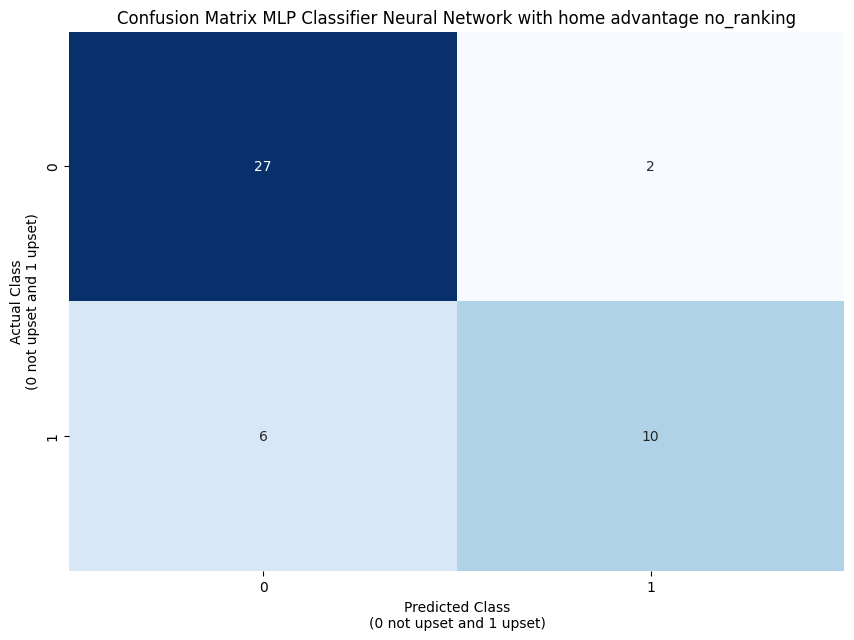

In [35]:
# MCP Neural Network with home advantage
model_name = "MLP Classifier Neural Network with home advantage"
home_advt = 'yes'
weighted = 'no'
max_iter = 10000
random_state = 47
model_classifier  = MLPClassifier()

# Define the ranking systems
ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

ranking_used =  'no_ranking'

# Split data into training and validation sets
fa_cup_features_train = fa_cup_features_all_df[~fa_cup_features_all_df['season_year'].isin(['21/22', '22/23'])]
fa_cup_features_val = fa_cup_features_all_df[fa_cup_features_all_df['season_year'].isin(['21/22', '22/23'])]

# Drop 'season_year' column from both sets
fa_cup_features_train = fa_cup_features_train.drop('season_year', axis=1)
fa_cup_features_val = fa_cup_features_val.drop('season_year', axis=1)

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_features_train.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]
display(base_features)

# Identify numeric and categorical columns
numeric_features = fa_cup_features_train[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_features_train[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

print(ranking_used)
if ranking_used == 'no_ranking':
    features = base_features
else:
    features = base_features + [f'home_team_{ranking_used}', f'away_team_{ranking_used}']
print(features)
# Create X_train and y_train
X_train = fa_cup_features_train[features]
y_train = fa_cup_features_train[target_variable]

# Create X_val and y_val
X_val = fa_cup_features_val[features]
y_val = fa_cup_features_val[target_variable]

display(fa_cup_features_val)


if home_advt == 'yes':
    X_train, home_advantage_column = add_home_advantage(X_train)
    X_val, _ = add_home_advantage(X_val)
    numeric_features = [home_advantage_column] + numeric_features

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

if ranking_used != 'no_ranking':
    preprocessor.transformers.append(('rank', ranking_transformer, [f'home_team_{ranking_used}', f'away_team_{ranking_used}']))

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model_classifier)
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions

y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]


# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
cr = classification_report(y_val, y_pred, output_dict=True)

model_name_ranking = f"{model_name} {ranking_used}"

results_df, cm_fig, roc_fig = create_model_results_df(y_val, y_pred, accuracy, recall, None, model_name_ranking)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', model_name_ranking]]


# Print results
#print(f"Results for {ranking}:")
#print(f"Accuracy: {accuracy}")
#print(f"Recall: {recall}")
#print("Confusion Matrix:")
#print(cm)
#print("Classification Report:")
#print(classification_report(y_val, y_pred))
#print("\n")


# Create a DataFrame with features, actual target, and predicted target
comparison_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred
})

comparison_df_reset = comparison_df.reset_index(drop=True)
display(comparison_df_reset)
X_val_reset = X_val.reset_index(drop=True)
display(X_val_reset)

all_data_act_pred_df = pd.concat([comparison_df_reset, X_val_reset])
all_data_act_pred_df  = comparison_df_reset.merge(X_val_reset, left_index=True, right_index=True)
display(all_data_act_pred_df )

display(results_df)



In [ ]:
# MCP Neural Network with home advantage
model_name = "MLP Classifier Neural Network with home advantage"
home_advt = 'yes'
weighted = 'no'
max_iter = 10000
random_state = 47
model_classifier  = MLPClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_iter': [max_iter],
    'classifier__random_state': [random_state],
    'classifier__hidden_layer_sizes': [(10,10,10), (20,20,), (10,)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_nnh = all_results_df
display(all_results_df_nnh)

fold_results_df_nnh = fold_results_df
display(fold_results_df_nnh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nnh.to_excel("all_nnh_results.xlsx")
fold_results_df_nnh.to_excel("fold_results_nnh.xlsx")

In [ ]:
# Random Forest Classifier
model_name = "Random Forest Classifier"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [ None, 'sqrt']
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_rf = all_results_df
display(all_results_df_rf)

fold_results_df_rf = fold_results_df
display(fold_results_df_rf)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rf.to_excel("all_rf_results.xlsx")
fold_results_df_rf.to_excel("fold_results_rf.xlsx")


In [ ]:
# Random Forest Classifier with home advantage
model_name = "Random Forest Classifier with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [ None, 'sqrt']
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_rfh = all_results_df
display(all_results_df_rfh)

fold_results_df_rfh = fold_results_df
display(fold_results_df_rfh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rfh.to_excel("all_rfh_results.xlsx")
fold_results_df_rfh.to_excel("fold_results_rfh.xlsx")

In [ ]:
# XG Boost
model_name = "XG Boost"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__max_depth': [3,5],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [ 0.8, 1.0],
    'classifier__colsample_bytree': [ 0.6, 1.0],
    'classifier__learning_rate':  [0.01, 0.1]
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_xg = all_results_df
display(all_results_df_xg)

fold_results_df_xg = fold_results_df
display(fold_results_df_xg)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xg.to_excel("all_xg_results.xlsx")
fold_results_df_xg.to_excel("fold_results_xg.xlsx")

In [ ]:
# XG Boost with home advantage
model_name = "XG Boost with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__max_depth': [3,5],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [ 0.8, 1.0],
    'classifier__colsample_bytree': [ 0.6, 1.0],
    'classifier__learning_rate':  [0.01, 0.1]
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_xgh = all_results_df
display(all_results_df_xgh)

fold_results_df_xgh = fold_results_df
display(fold_results_df_xgh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xgh.to_excel("all_xgh_results.xlsx")
fold_results_df_xgh.to_excel("fold_results_xgh.xlsx")

In [ ]:
all_results_df = all_results_df_xg.merge(all_results_df_xgh, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rfh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rf.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nnh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nn.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_slrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_slr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')

all_results_df = all_results_df.rename(columns=lambda x: x.lower().replace(' ','(_)').replace('(', '').replace(')', ''))
display(all_results_df)
all_results_df.to_excel("ml_model_confusion_matrix_results.xlsx")

# Load data from Excel to Google BigQuery
all_results_from_excel = pd.read_excel("all_results.xlsx")
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"

pandas_gbq.to_gbq(all_results_from_excel, full_table_name,
                  project_id='birkbeck-msc-project-422917',
                  if_exists='replace')

print(f"\nData loaded to BigQuery table: {full_table_name}")


,metric_id,metric,standard_logisticregression_with_home_advantage_no_ranking,standard_logisticregression_with_home_advantage_round_3_position,standard_logisticregression_with_home_advantage_massey,standard_logisticregression_with_home_advantage_colley,standard_logisticregression_with_home_advantage_keener,standard_logisticregression_with_home_advantage_trueskill,standard_logisticregression_with_home_advantage_borda_count,standard_logisticregression_with_home_advantage_local_kemeny_optimisation,...,xg_boost_borda_count,xg_boost_local_kemeny_optimisation,xg_boost_with_home_advantage_no_ranking,xg_boost_with_home_advantage_round_3_position,xg_boost_with_home_advantage_massey,xg_boost_with_home_advantage_colley,xg_boost_with_home_advantage_keener,xg_boost_with_home_advantage_trueskill,xg_boost_with_home_advantage_borda_count,xg_boost_with_home_advantage_local_kemeny_optimisation
0,1,Cross-validation Accuracy Mean,0.682,0.702,0.682,0.672,0.656,0.682,0.682,0.682,...,0.856,0.862,0.816,0.816,0.810,0.784,0.780,0.793,0.820,0.807
1,2,Cross-validation Accuracy Standard Deviation,0.030,0.026,0.040,0.045,0.048,0.030,0.043,0.043,...,0.060,0.075,0.039,0.048,0.027,0.028,0.030,0.029,0.075,0.064
2,3,Cross-validation Recall Mean,0.207,0.257,0.219,0.195,0.171,0.220,0.232,0.232,...,0.496,0.508,0.538,0.574,0.499,0.428,0.438,0.453,0.499,0.500
3,4,Cross-validation Recall Standard Deviation,0.049,0.029,0.046,0.021,0.061,0.051,0.046,0.046,...,0.261,0.316,0.178,0.164,0.188,0.206,0.238,0.183,0.264,0.292
4,5,Overall Accuracy,0.682,0.702,0.682,0.672,0.656,0.682,0.682,0.682,...,0.856,0.862,0.816,0.816,0.810,0.784,0.780,0.793,0.820,0.807
5,6,Confusion Matrix - True Negative (Class 0),191.000,193.000,190.000,189.000,186.000,190.000,189.000,189.000,...,220.000,221.000,205.000,202.000,206.000,204.000,202.000,205.000,209.000,205.000
6,7,Confusion Matrix - False Positive (Class 1),32.000,30.000,33.000,34.000,37.000,33.000,34.000,34.000,...,3.000,2.000,18.000,21.000,17.000,19.000,21.000,18.000,14.000,18.000
7,8,Confusion Matrix - False Negative (Class 0),65.000,61.000,64.000,66.000,68.000,64.000,63.000,63.000,...,41.000,40.000,38.000,35.000,41.000,47.000,46.000,45.000,41.000,41.000
8,9,Confusion Matrix - True Positive (Class 1),17.000,21.000,18.000,16.000,14.000,18.000,19.000,19.000,...,41.000,42.000,44.000,47.000,41.000,35.000,36.000,37.000,41.000,41.000
9,10,Precision (Class 0),0.746,0.760,0.748,0.741,0.732,0.748,0.750,0.750,...,0.843,0.847,0.844,0.852,0.834,0.813,0.815,0.820,0.836,0.833


100%|██████████| 1/1 [00:00<00:00, 1402.78it/s]


Data loaded to BigQuery table: analysis_layer.ml_model_confusion_matrix_results


In [ ]:
# Load updated Fold results to Google Big Query

# Merge fold results from each model
fold_results_df = pd.concat([fold_results_df_slr, fold_results_df_slrh, fold_results_df_wlrh, fold_results_df_nn, fold_results_df_nnh, fold_results_df_rf, fold_results_df_rfh, fold_results_df_xg, fold_results_df_xgh])
fold_results_df = fold_results_df.rename(columns=lambda x: x.lower().replace(' ','(_)').replace('(', '').replace(')', ''))
display(fold_results_df)

# Write to Excel
fold_results_df.to_excel("ml_model_fold_results.xlsx")

# Load fold results data from Excel to Google BigQuery
fold_results_from_excel = pd.read_excel("all_results_.xlsx")
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_fold_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"

pandas_gbq.to_gbq(fold_results_from_excel, full_table_name,
                  project_id='birkbeck-msc-project-422917',
                  if_exists='replace')

print(f"\nData loaded to BigQuery table: {full_table_name}")


,model_name_ranking,fold,best_parameters_gridsearchcv,best_recall_gridsearchcv,validation_accuracy,validation_recall
0,Standard LogisticRegression no_ranking,1,"{'classifier__C': 10.0, 'classifier__penalty':...",0.348485,0.704918,0.187500
1,Standard LogisticRegression no_ranking,2,"{'classifier__C': 1000.0, 'classifier__penalty...",0.409091,0.639344,0.250000
2,Standard LogisticRegression no_ranking,3,"{'classifier__C': 100.0, 'classifier__penalty'...",0.348485,0.639344,0.187500
3,Standard LogisticRegression no_ranking,4,"{'classifier__C': 10.0, 'classifier__penalty':...",0.411255,0.688525,0.117647
4,Standard LogisticRegression no_ranking,5,"{'classifier__C': 1000.0, 'classifier__penalty...",0.383117,0.721311,0.176471
...,...,...,...,...,...,...
35,XG Boost with home advantage local_kemeny_opti...,1,"{'classifier__colsample_bytree': 1.0, 'classif...",0.742424,0.918033,0.687500
36,XG Boost with home advantage local_kemeny_opti...,2,"{'classifier__colsample_bytree': 1.0, 'classif...",0.621212,0.770492,0.812500
37,XG Boost with home advantage local_kemeny_opti...,3,"{'classifier__colsample_bytree': 1.0, 'classif...",0.803030,0.737705,0.000000
38,XG Boost with home advantage local_kemeny_opti...,4,"{'classifier__colsample_bytree': 1.0, 'classif...",0.601732,0.836066,0.647059


100%|██████████| 1/1 [00:00<00:00, 10810.06it/s]


Data loaded to BigQuery table: analysis_layer.ml_model_fold_results
